# machine learning project
> model to predict/recognize animal images (cats,dogs) <br><br>
> the model is based on tensorflow keras api <br><br>
> working with 30k grayscaled images of cats and dogs<br><br>

In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d UNMOVED/30k-cats-and-dogs-150x150-greyscale
# !unzip 30k-cats-and-dogs-150x150-greyscale.zip

## importing libraries

In [2]:
import numpy as np
import pandas as pd

from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential

from keras.layers import Dense, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D, InputLayer
from keras.optimizers import Adam


from sklearn.metrics import confusion_matrix, classification_report

## creating the path to the data 
 identifying which bath is which for the cats and dogs

In [16]:
# creating the path
image_dir = Path('Animal Images')

# Create File DataFrame

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
print(image_df)

                                          Filepath Label
0              Animal Images\cats\00001098_028.jpg  cats
1              Animal Images\cats\00001099_003.jpg  cats
2              Animal Images\cats\00001099_004.jpg  cats
3              Animal Images\cats\00001099_009.jpg  cats
4              Animal Images\cats\00001099_011.jpg  cats
...                                            ...   ...
30055  Animal Images\dogs\yorkshire_terrier_95.jpg  dogs
30056  Animal Images\dogs\yorkshire_terrier_96.jpg  dogs
30057  Animal Images\dogs\yorkshire_terrier_97.jpg  dogs
30058  Animal Images\dogs\yorkshire_terrier_98.jpg  dogs
30059  Animal Images\dogs\yorkshire_terrier_99.jpg  dogs

[30060 rows x 2 columns]


## splitting data for training ,validation ,testing

In [18]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [19]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150,150),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(150, 150),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 16834 validated image filenames belonging to 2 classes.
Found 4208 validated image filenames belonging to 2 classes.
Found 9018 validated image filenames belonging to 2 classes.


## visualizing the data

In [20]:
batch = train_images[1]
x, y = batch
print(x)

[[[[0.5998709 ]
   [0.6024363 ]
   [0.60349554]
   ...
   [0.57169694]
   [0.57169694]
   [0.57169694]]

  [[0.60349554]
   [0.6037925 ]
   [0.6063579 ]
   ...
   [0.57604456]
   [0.57604456]
   [0.57604456]]

  [[0.6039216 ]
   [0.6063579 ]
   [0.60771406]
   ...
   [0.5799661 ]
   [0.5799661 ]
   [0.5799661 ]]

  ...

  [[0.76387405]
   [0.78229356]
   [0.7745693 ]
   ...
   [0.61960787]
   [0.61960787]
   [0.61960787]]

  [[0.76387405]
   [0.78229356]
   [0.7745693 ]
   ...
   [0.61960787]
   [0.61960787]
   [0.61960787]]

  [[0.76387405]
   [0.78229356]
   [0.7745693 ]
   ...
   [0.61960787]
   [0.61960787]
   [0.61960787]]]


 [[[0.6084649 ]
   [0.6192546 ]
   [0.6241727 ]
   ...
   [0.01176471]
   [0.01176471]
   [0.01176471]]

  [[0.61570007]
   [0.625086  ]
   [0.6241257 ]
   ...
   [0.01338296]
   [0.01338296]
   [0.01338296]]

  [[0.6193852 ]
   [0.62336695]
   [0.6016183 ]
   ...
   [0.02041697]
   [0.02041697]
   [0.02041697]]

  ...

  [[0.57352406]
   [0.5774456 ]
   [0.5

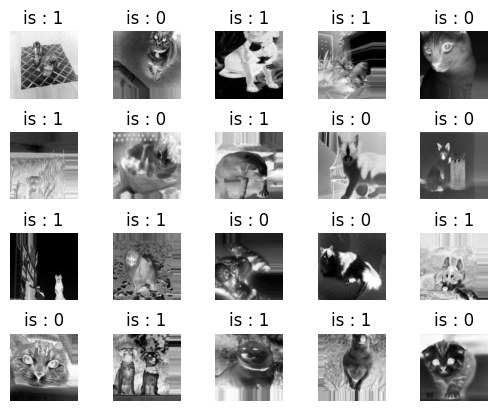

In [5]:
for i in range(20):
  plt.subplot(4,5,i+1)
  batch = train_images[i]
  x, y = batch
  plt.imshow(x[i],cmap='gray_r')
  plt.title("is : {:.0f}".format(y[i]))
  plt.subplots_adjust(hspace=0.5)
  plt.axis('off')
    

# ANN:

In [6]:
ann_model = Sequential([
    Flatten(input_shape=(150, 150, 1)),
    Dense(256, 'relu'),
    Dense(128, 'relu'),
    Dense(1, 'sigmoid')
])

optimizer = Adam(learning_rate=0.00001)
ann_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = ann_model.fit(
    train_images,
    validation_data=test_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=6,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=3
        )
    ]
)

In [ ]:
ann_model.save('project_ANN.h5')

In [3]:
ann_model=tf.keras.models.load_model('project_ANN.h5')

In [9]:
results = ann_model.evaluate(test_images, verbose=1)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

282/282 [==============================] - 8s 29ms/step - loss: 0.6729 - accuracy: 0.5798
Test Loss: 0.67286
Test Accuracy: 57.98%


282/282 [==============================] - 4s 16ms/step
Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.61      0.52      0.56      4634
         DOG       0.56      0.64      0.60      4384

    accuracy                           0.58      9018
   macro avg       0.58      0.58      0.58      9018
weighted avg       0.58      0.58      0.58      9018



C:\Users\Blu-ray\AppData\Local\Temp\ipykernel_29288\3631510178.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = (ann_model.predict(test_images) >= 0.5).astype(np.int)


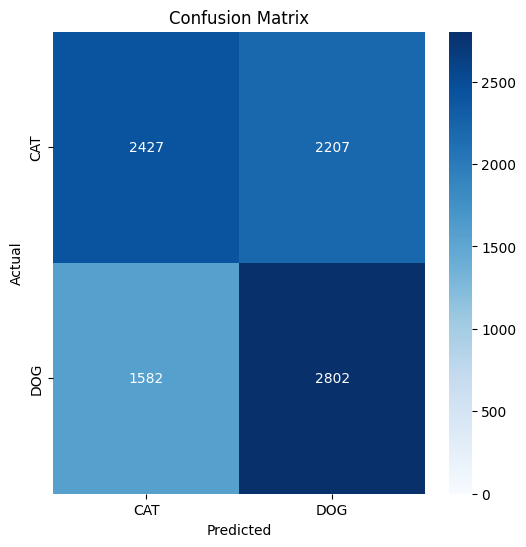

In [10]:
predictions = (ann_model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=True)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix");

print("Classification Report:\n----------------------\n", clr)

# CNN:

## making the model

In [15]:
# inputs = tf.keras.Input(shape=(150, 150,1))
# x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
# x = MaxPool2D()(x)
# x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
# x = MaxPool2D()(x)
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# outputs = Dense(1, activation='sigmoid')(x)
# model = tf.keras.Model(inputs=inputs, outputs=outputs)



# model = Sequential()
# ################################# CNN ######################################################
# model.add(Conv2D(filters = 12, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu', input_shape = train_images.shape[1:]))
# model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Conv2D(filters = 24, kernel_size = (3,3),padding = 'Same', 
#                  activation ='relu'))
# model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# ################################# Fully Connected #########################################
# model.add(Flatten())
# model.add(Dense(512, activation = "relu"))
# model.add(Dropout(0.1))
# model.add(Dense(test_images.shape[1], activation = "sigmoid"))


model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

## compiling the model

In [16]:
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## train/fiting the model

In [ ]:
# model.fit(train_images,validation_data=val_images,epochs=100)
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=10
        )
    ]
)

In [ ]:
model.save('project_CNN.h5')

In [4]:
model=tf.keras.models.load_model('project_CNN.h5')

## evaluating the results 

#### Accuracy and Loss

In [12]:
results = model.evaluate(test_images, verbose=1)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

282/282 [==============================] - 13s 46ms/step - loss: 0.3043 - accuracy: 0.8682
Test Loss: 0.30432
Test Accuracy: 86.82%


#### confusion matrix and classification report
>(precision, recall, f1-score, support)

282/282 [==============================] - 13s 45ms/step


C:\Users\Blu-ray\AppData\Local\Temp\ipykernel_29288\3693395307.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = (model.predict(test_images) >= 0.5).astype(np.int)


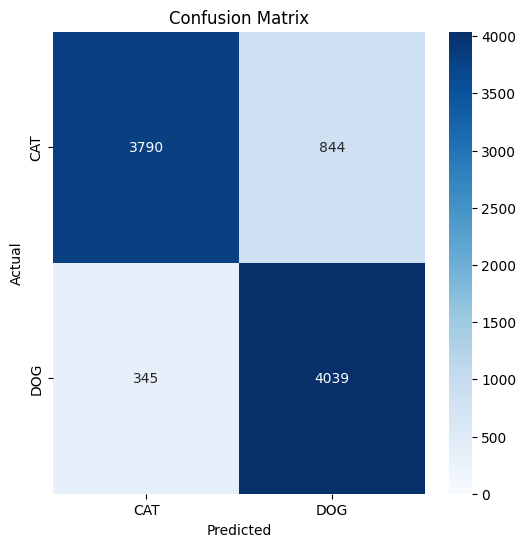

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.92      0.82      0.86      4634
         DOG       0.83      0.92      0.87      4384

    accuracy                           0.87      9018
   macro avg       0.87      0.87      0.87      9018
weighted avg       0.87      0.87      0.87      9018



In [13]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=True)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

## predict from an outer image

In [5]:
# make a prediction for a new image.
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import Image,display
from PIL import ImageOps
# load and prepare the image
def make_new_prediction(filename):
	# load the image
	img = load_img(filename, grayscale=True,target_size=(150, 150,1))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 1 channel
	img = img.reshape(1,150, 150,1)
	# prepare pixel data/normalizing
	img = img.astype('float32')
	img = img / 255.0
	# now it shows you the real image you uploaded
	print("the real photo image")
	display(Image(filename,width=250,height=250))
	# here it makes the predication of what is the number in the image
	digit=model.predict(img)
	print(digit)
	if np.sign(digit[0] - 0.5) < 0:
		print("the predict animal is : cat")
	else:
		print("the predict animal is : dog")

the real photo image


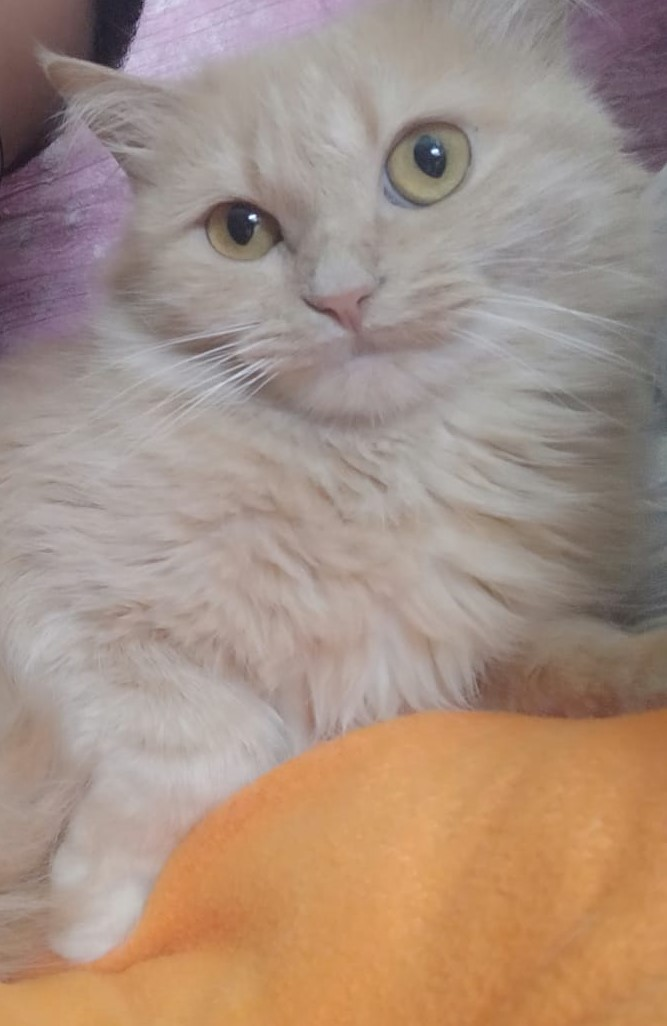

1/1 [==============================] - 0s 45ms/step
[[0.16803014]]
the predict animal is : cat


In [14]:
make_new_prediction("to_test/pooh1.jpg")